In [15]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_metrics_over_datasets.ipynb

[NbConvertApp] Converting notebook compare_metrics_over_datasets.ipynb to python
[NbConvertApp] Writing 9661 bytes to compare_metrics_over_datasets.py


In [2]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

import openml

import sklearn.metrics
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.base
import sklearn.utils
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.tree

from ridgereliability import plots, metrics

import os
import multiprocessing
import logging
import time
from joblib import load, dump

In [3]:
def is_notebook():
    try:
        from IPython import get_ipython
        return get_ipython().__class__.__name__ == 'ZMQInteractiveShell'
    except ModuleNotFoundError:
        return False

In [4]:
if is_notebook():
    n_procs = multiprocessing.cpu_count()//2
    random_tasks = 2
else:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--n-processes", type=int, required=True)
    parser.add_argument("--random-tasks", type=int, default=0)
    args = parser.parse_args()
    n_procs = args.n_processes
    random_tasks = args.random_tasks

In [5]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s - %(message)s')
logging.captureWarnings(True)

In [6]:
numpy.random.seed(42)

# Compare metrics over datasets

In this notebook we collect calibration estimates for several models and datasets. The estimates are computed with the Expected Calibration Error (ECE), Balanced-ECE, and Posterior Expected Accuracy-based Calibration Error (PEACE).

Tested models:
- Random Forest
- SVM
- Logistic Regression
- Gaussian Naive Bayes
- MLP
- AdaBoost
- Decision Tree

Tested datasets (from Open ML):
- [eeg-eye-state](https://www.openml.org/d/1471), task [9983](https://www.openml.org/t/9983)
- [Phoneme](https://www.openml.org/d/1489), task [9952](https://www.openml.org/t/9952)
- [mozilla4](https://www.openml.org/d/1046), task [3899](https://www.openml.org/t/3899)
- [electricity](https://www.openml.org/d/151), task [219](https://www.openml.org/t/219)
- [Magic Telescope](https://www.openml.org/d/1120), task [3954](https://www.openml.org/t/3954)
- [artificial characters](https://www.openml.org/d/1459), task [14964](https://www.openml.org/t/14964)
- [pendigits](https://www.openml.org/d/32), task [32](https://www.openml.org/t/32)
- [letter](https://www.openml.org/d/6), task [6](https://www.openml.org/t/6)
- [JapaneseVowels](https://www.openml.org/d/375), task [3510](https://www.openml.org/t/3510)
- [glass](https://www.openml.org/d/41), task [40](https://www.openml.org/t/40)
- [micro-mass](https://www.openml.org/d/1515), task [9950](https://www.openml.org/t/9950)
- [vehicle](https://www.openml.org/d/54), task [53](https://www.openml.org/t/53)
- [synthetic-control](https://www.openml.org/d/377), task [3512](https://www.openml.org/t/3512)
- [mfeat-factors](https://www.openml.org/d/12), task [12](https://www.openml.org/t/12)
- [OVA_breast](https://www.openml.org/d/1128), task [3962](https://www.openml.org/d/1128)
- [sonar](https://www.openml.org/d/40), task [39](https://www.openml.org/t/39)
- [visualizing_livestock](https://www.openml.org/d/685), task [3577](https://www.openml.org/t/3577)
- [spectrometer](https://www.openml.org/d/313), task [145682](https://www.openml.org/t/145682)
- [disclosure_z](https://www.openml.org/d/931), task [3794](https://www.openml.org/t/3794)
- [mfeat-pixel](https://www.openml.org/d/40979), task [146824](https://www.openml.org/t/146824)

## Datasets

First of all, we need to be able to load and preprocess multiple datasets appropriately to prepare it for classification. 
To this end we implement a function that will load a dataset and classification task from OpenML.

In [6]:
def find_random_task(offset):
    while True:
        df = openml.tasks.list_tasks(task_type_id=1, offset=offset, output_format="dataframe", size=10000, status="active", number_missing_values=0)
        if "NumberOfInstances" in df:
            df = df[(df["NumberOfInstances"] > 100) & (df["NumberOfInstances"] < 1000)]
            if len(df) > 0:
                return df.sample(n=1).iloc[0]["tid"]

In [7]:
if random_tasks > 0:
    TASKS = random_tasks
else:
    TASKS = [9983, 9952, 3899, 219, 3954, 14964, 32, 6, 3510, 40, 9950, 53, 3512, 12, 3962, 39, 3577, 145682, 3794, 146824]

In [8]:
def load_openml_task(task_id=None, offset=0):
    
    while True:
        if task_id is None:
            curr_id = find_random_task(offset)
        else:
            curr_id = task_id

        try: 
            task = openml.tasks.get_task(curr_id)
            X, y = task.get_X_and_y("array")
            X, y = sklearn.utils.indexable(X, y)
            
            target_type = sklearn.utils.multiclass.type_of_target(y)
            if target_type not in ["binary", "multiclass"]:
                continue

            if hasattr(X, "toarray"):
                X = X.toarray()
            if hasattr(y, "toarray"):
                y = y.toarray()

            X = sklearn.preprocessing.OrdinalEncoder().fit_transform(X)

            n_repeats, n_folds, n_samples = task.get_split_dimensions()
            
            if n_folds > 10:
                continue

            folds = numpy.full((len(X)), dtype=int, fill_value=-1)
            for fold_idx in range(n_folds):
                _, test_indices = task.get_train_test_split_indices(
                    repeat=0,
                    fold=fold_idx,
                    sample=0,
                )

                folds[test_indices] = fold_idx

            splitter = sklearn.model_selection.PredefinedSplit(folds)

            return X, y, splitter, curr_id
        except:
            if task_id is not None:
                raise e

In [9]:
# noscript
X, y, splitter, task_id = load_openml_task(9952)

INFO: 2020-09-25 16:12:52,016 - pickle load data phoneme


In [10]:
# noscript
X, y, splitter, task_id = load_openml_task()

INFO: 2020-09-25 16:12:52,129 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/10000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-25 16:12:52,664 - 0.5329504s taken for [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/10000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-25 16:12:53,106 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-25 16:12:53,171 - 0.0648108s taken for [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-25 16:12:53,248 - pickle load data wdbc


## Getting calibration metrics

For each dataset we fit and evaluate multiple models. We record calibration metrics (ECE, ECE-balanced, PEACE), and some performance metrics (balanced accuracy, F1-score, accuracy). To this end we implement a function that runs this procedure for one model on one OpenML task.

In [11]:
MODELS = {
    "rf": sklearn.ensemble.RandomForestClassifier(),
    "svm": sklearn.svm.SVC(probability=True),
    "logreg": sklearn.linear_model.LogisticRegression(max_iter=1000),
    "nb": sklearn.naive_bayes.GaussianNB(),
    "mlp": sklearn.neural_network.MLPClassifier(max_iter=1000),
    "adaboost": sklearn.ensemble.AdaBoostClassifier(n_estimators=500),
    "dectree": sklearn.tree.DecisionTreeClassifier()
}

In [12]:
def get_fold_metrics_for_model(row, Xt, yt, Xv, yv):
    # get and fit fresh model
    model = sklearn.base.clone(MODELS[row["model_id"]])
    model.fit(Xt, yt)

    # compute metrics on test data
    y_probs = model.predict_proba(Xv)
    y_probs_max = y_probs.max(axis=1)
    y_preds = model.predict(Xv)
    y_test = yv

    bins = 15
    row.update({
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
        "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
        "f1": sklearn.metrics.f1_score(y_test, y_preds, average="weighted"),
        'ece': metrics.ece(y_probs_max, y_preds, y_test, bins=bins),
        'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=bins),
        'peace': metrics.peace(y_probs_max, y_preds, y_test, bins=bins),
        'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, bins=bins),
        'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace, bins=bins)
    })
    
    return row

In [13]:
def get_cv_metrics_for_model_and_task(model_id, task_id, pool, n_repeats, counter, start_at):
    
    X, y, splitter, task_id = load_openml_task(task_id, offset=counter) # repeated runs will use cached data
    
    promises = []
    for i, (train_idx, test_idx) in enumerate(splitter.split()):
        for j in range(n_repeats):
            counter += 1
            if counter < start_at:
                continue
            
            row = {
                "fold": i,
                "repeat": j,
                "model_id": model_id,
                "task_id": task_id,
            }

            # split data
            Xt, yt = X[train_idx], y[train_idx]
            Xv, yv = X[test_idx], y[test_idx]

            promise = pool.apply_async(
                get_fold_metrics_for_model,
                (row, Xt, yt, Xv, yv)
            )
            promises.append(promise)
    
    logging.info(f"Promises for single cv: {len(promises)}")
    return promises, counter

## Data collection over all datasets and models

In [14]:
with multiprocessing.Pool(processes=n_procs) as pool:

    start_at = 0

    output_file = f"metrics_{int(time.time())}.dat"
    logging.info(f"Output to {output_file}")

    promises = []
    counter = 0
    
    if type(TASKS) is int:
        iter_tasks = [None]*TASKS
    else:
        iter_tasks = TASKS
    
    for model_id in MODELS.keys():
        for task_id in iter_tasks:
            tmp, counter = get_cv_metrics_for_model_and_task(model_id, task_id, pool, 1, counter, start_at)
            promises.extend(tmp)
            logging.info(f"{len(promises)} promises submitted to pool ({model_id, task_id})")

    logging.info(f"{len(promises)} promises submitted to pool")

    data = []
    for promise in promises:
        data.append(promise.get())
        logging.info(f"Finished promises: {len(data)}/{len(promises)} ({len(data)/len(promises)*100:.2f}%)")
        df = pandas.DataFrame(data)
        dump(df, output_file)

INFO: 2020-09-25 16:12:54,036 - Output to metrics_1601043174.dat
INFO: 2020-09-25 16:12:54,046 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/10000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-25 16:12:54,505 - 0.4574637s taken for [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/10000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-25 16:12:54,937 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-25 16:12:55,001 - 0.0630882s taken for [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-25 16:12:55,084 - pickle load data grub-damage
INFO: 2020-09-25 16:12:55,102 - Promises for single cv: 10
INFO: 2020-09-25 16:12:55,103 - 10 promises submitted to pool (('rf', None))
INFO: 2020-09-25 16:12:55,104 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/li

KeyboardInterrupt: 

In [16]:
if not is_notebook():
    exit()

# Analysis

In [7]:
df = load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random/metrics_1601149607.dat")

In [11]:
df

,fold,repeat,model_id,task_id,accuracy,balanced_accuracy,f1,ece,ece_balanced,peace,class_wise_ece,class_wise_peace
0,0,0,rf,None,0.6875,0.609091,0.676932,0.270000,0.285625,0.238462,0.365833,0.275059
1,1,0,rf,None,0.8125,0.754545,0.806159,0.281875,0.281875,0.223394,0.342083,0.254650
2,2,0,rf,None,0.7500,0.654545,0.729167,0.317500,0.301875,0.288443,0.356667,0.304324
3,3,0,rf,None,0.6250,0.563636,0.625000,0.323125,0.291875,0.289090,0.355000,0.288638
4,4,0,rf,None,0.8125,0.754545,0.806159,0.301250,0.332500,0.287512,0.365833,0.288427
...,...,...,...,...,...,...,...,...,...,...,...,...
228,5,0,dectree,None,0.7800,0.778846,0.779735,0.220000,0.221154,0.241741,0.219807,0.240690
229,6,0,dectree,None,0.8200,0.817308,0.818909,0.180000,0.182692,0.205956,0.174877,0.199860
230,7,0,dectree,None,0.7800,0.782051,0.779736,0.220000,0.217949,0.238988,0.216586,0.237931
231,8,0,dectree,None,0.8000,0.802885,0.799359,0.200000,0.197115,0.219719,0.193182,0.216667


In [8]:
grouped_df = df.groupby(["model_id", "task_id", "repeat"]).aggregate("mean").drop(columns=["fold"]).reset_index()

In [9]:
grouped_df

,model_id,task_id,repeat,accuracy,balanced_accuracy,f1,ece,ece_balanced,peace,class_wise_ece,class_wise_peace


In [20]:
def get_longform(df, cols=None, subject_cols=None):
    dfs = []
    
    if cols is None:
        cols = df.columns
    
    for col in cols:
        tmp_df = pandas.DataFrame(dict(        
            value=df[col], 
            metric=col,   
        ))
        for col2 in set(df.columns) - set(cols):
            tmp_df[col2] = df[col2]
            
        if subject_cols is not None:
            tmp_df["subject"] = df[subject_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
            
        dfs.append(tmp_df)
        
    return pandas.concat(dfs)

In [21]:
long_df = get_longform(grouped_df, grouped_df.columns[3:], ["model_id", "task_id"])

In [22]:
long_df.shape

(1120, 6)

In [23]:
long_df.head()

,value,metric,model_id,task_id,repeat,subject
0,0.263050,accuracy,adaboost,6,0,adaboost_6
1,0.406500,accuracy,adaboost,12,0,adaboost_12
2,0.372635,accuracy,adaboost,32,0,adaboost_32
3,0.816429,accuracy,adaboost,39,0,adaboost_39
4,0.476190,accuracy,adaboost,40,0,adaboost_40


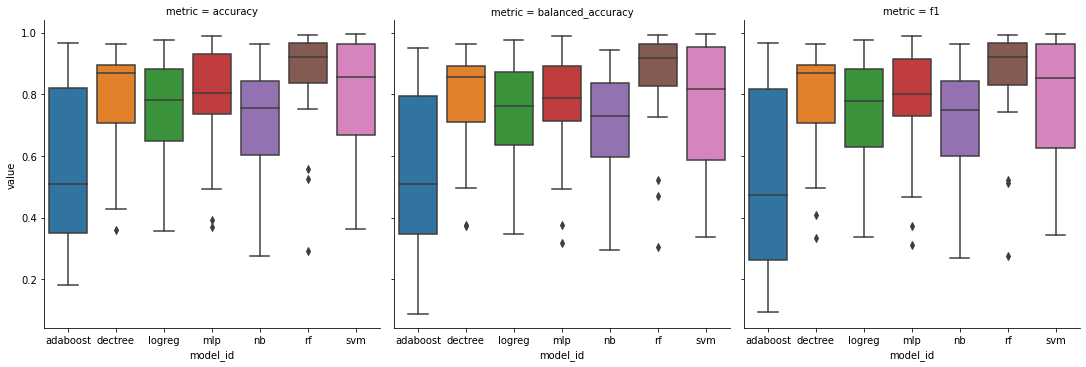

In [24]:
seaborn.catplot(data=long_df[long_df["metric"].isin(["accuracy", "balanced_accuracy", "f1"])], x="model_id", y="value", col="metric", kind="box")

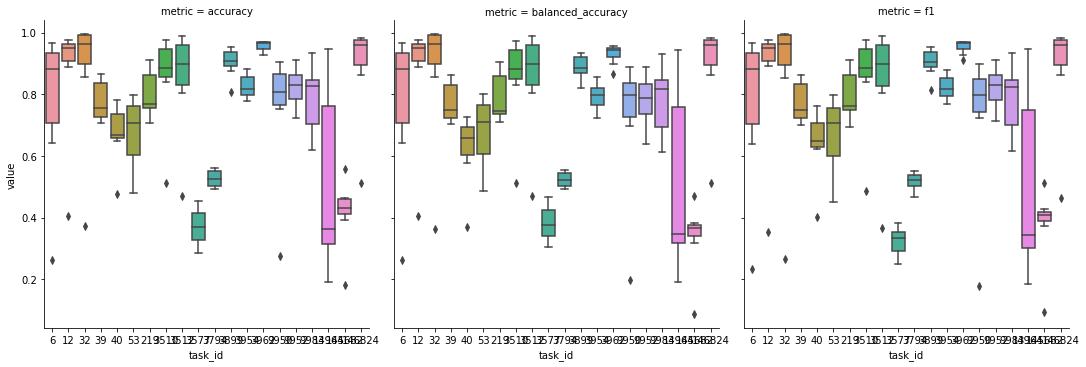

In [25]:
seaborn.catplot(data=long_df[long_df["metric"].isin(["accuracy", "balanced_accuracy", "f1"])], x="task_id", y="value", col="metric", kind="box")

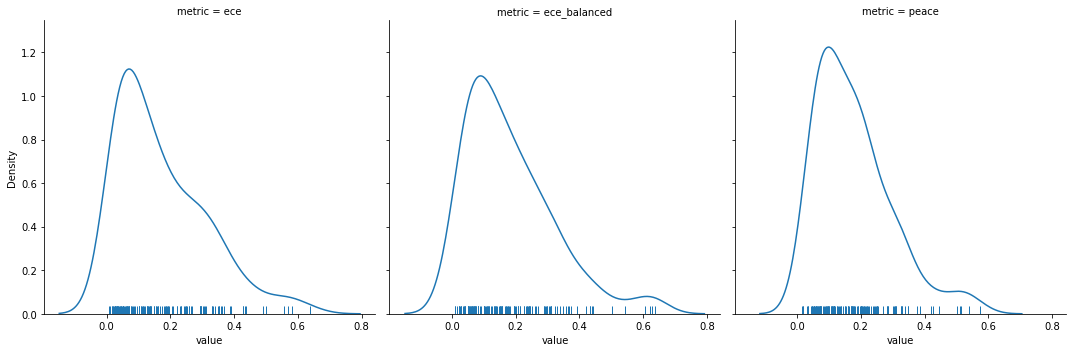

In [26]:
seaborn.displot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], x="value", col="metric", rug=True, kind="kde")

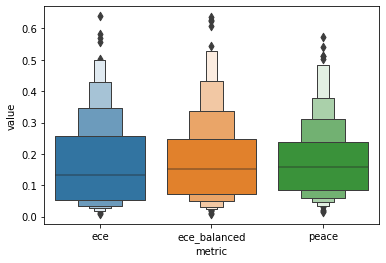

In [27]:
seaborn.boxenplot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], y="value", x="metric")

In [28]:
long_df["metric_ord"] = long_df["metric"].map(lambda a: numpy.unique(long_df["metric"]).tolist().index(a))

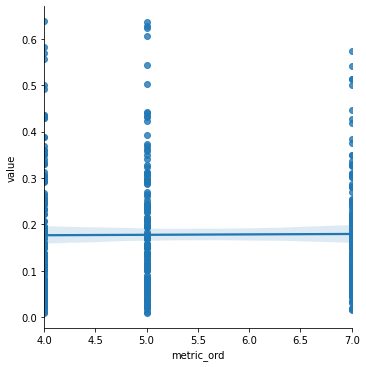

In [29]:
seaborn.lmplot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], y="value", x="metric_ord")

## Statistical testing

In [30]:
import scipy.stats
import scikit_posthocs as sp

### Pooled datasets + model

In [31]:
data = grouped_df.loc[grouped_df["repeat"] == 0, ["ece", "ece_balanced", "peace"]].values
scipy.stats.friedmanchisquare(data[0], data[1], data[2])

FriedmanchisquareResult(statistic=6.0, pvalue=0.04978706836786395)

In [32]:
long_data = get_longform(grouped_df.loc[grouped_df["repeat"] == 0, ["ece", "ece_balanced", "peace"]])
sp.posthoc_conover(long_data, val_col="value", group_col="metric", p_adjust="holm")

,ece,ece_balanced,peace
ece,-1.000000,0.668108,0.668108
ece_balanced,0.668108,-1.000000,0.799862
peace,0.668108,0.799862,-1.000000


### Per model

In [33]:
for idx, model_df in grouped_df.groupby("model_id"):
    data = model_df.loc[:, ["ece", "ece_balanced", "peace"]]
    test = scipy.stats.friedmanchisquare(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2])
    print(idx)
    print(test)
    if test.pvalue < 0.05:
        long_data = get_longform(data)
        print(sp.posthoc_conover(long_data, val_col="value", group_col="metric", p_adjust="holm"))

adaboost
FriedmanchisquareResult(statistic=4.900000000000006, pvalue=0.0862935864993703)
dectree
FriedmanchisquareResult(statistic=18.30000000000001, pvalue=0.00010621980274645822)
              ece  ece_balanced  peace
ece          -1.0           1.0    1.0
ece_balanced  1.0          -1.0    1.0
peace         1.0           1.0   -1.0
logreg
FriedmanchisquareResult(statistic=15.600000000000023, pvalue=0.0004097349789797821)
                   ece  ece_balanced     peace
ece          -1.000000      0.639421  0.280083
ece_balanced  0.639421     -1.000000  0.639421
peace         0.280083      0.639421 -1.000000
mlp
FriedmanchisquareResult(statistic=18.100000000000023, pvalue=0.0001173910369191168)
                   ece  ece_balanced     peace
ece          -1.000000           1.0  0.796384
ece_balanced  1.000000          -1.0  1.000000
peace         0.796384           1.0 -1.000000
nb
FriedmanchisquareResult(statistic=10.800000000000011, pvalue=0.00451658094261264)
                   ece 

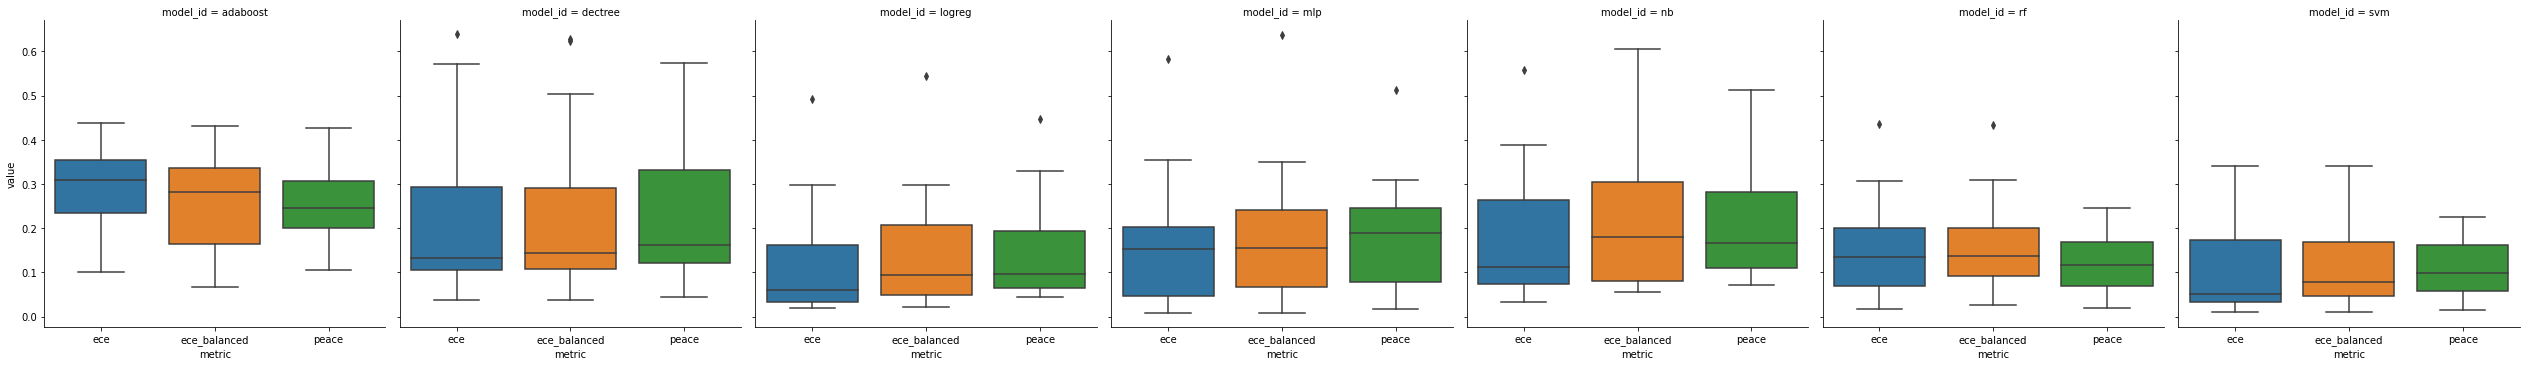

In [34]:
seaborn.catplot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], x="metric", y="value", col="model_id", kind="box")